In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
RUN_NAME = 'learn_dispense_v2_high_vel_final_2'
# RUN_NAME = 'baseline_2'
EP_INFO_PATH = f'eval_logs/{RUN_NAME}/rollout_data/test_batch_1_info'
ROLLOUT_DATA = f'eval_logs/{RUN_NAME}/rollout_data/test_batch_1'

In [3]:
MAX_ROT_ACC = np.pi / 4
MIN_ROT_ACC = -2 * MAX_ROT_ACC
MAX_ROT_VEL = np.pi / 32
MIN_ROT_VEL = -2 * MAX_ROT_VEL

OBS_DATA = ["error", "error_rate", "velocity", "acceleration", "pid_output", "angle_fb"]
OBS_HIST_LENGTH = [5, 5, 1, 1, 1, 1]
OBS_MEAN = [50, -25, 0, 0, 0, (np.pi / 6)]
OBS_STD = [50, 25, MAX_ROT_VEL, MAX_ROT_ACC, MAX_ROT_VEL, (np.pi / 6)]

In [4]:
def load_and_process_episode_data(path):
    f = open(path, 'rb')
    data = pickle.load(f)
    data, success = data['episode'], data['is_success']
    data = dict([(k, [ep[k] for ep in data]) for k in data[0].keys()])
    data['is_success'] = success
    return data


def load_and_process_rollout_data(path):
    f = open(path, 'rb')
    data = pickle.load(f)

    obs_data = data.pop('obs')

    obs_idx = [0,]
    for i in OBS_HIST_LENGTH[:-1]:
        obs_idx.append(obs_idx[-1] + i)

    obs_data = obs_data[:, obs_idx]
    obs_data = obs_data * np.array(OBS_STD) + np.array(OBS_MEAN)

    for o, v in zip(OBS_DATA, obs_data.T):
        data[o] = v

    episode_slice_idx = []
    for idx in range(len(data['episode_start'])):
        if data['episode_start'][idx] == 1:
            episode_slice_idx.append(idx)
    episode_slice_idx.append(len(data['episode_start']))
    data['episode_slice_idx'] = episode_slice_idx

    return data

In [5]:
ep_data = load_and_process_episode_data(EP_INFO_PATH)
rollout_data = load_and_process_rollout_data(ROLLOUT_DATA)

In [6]:
(
    np.mean(ep_data['dispense_time']), 
    np.mean(ep_data['is_success']),
    np.abs(np.array(ep_data['requested_wt']) - np.array(ep_data['dispensed_wt'])).mean()
)

(19.643031816482544, 0.96, 1.8500029945373535)

In [7]:
(
    np.std(ep_data['dispense_time']),
    np.abs(np.array(ep_data['requested_wt']) - np.array(ep_data['dispensed_wt'])).std()
)

(3.582952720107883, 1.2137610119336937)

In [8]:
def plot_controller_output(episode_no, rollout_data, ep_data, show_clipped=False):
    start_idx = rollout_data['episode_slice_idx'][episode_no]
    end_idx = rollout_data['episode_slice_idx'][episode_no+1]

    t = rollout_data['time'][start_idx:end_idx]
    pid = np.rad2deg(rollout_data['pid_output'][start_idx:end_idx])
    net = np.rad2deg(rollout_data['net_velocity'][start_idx:end_idx])
    rl_clip = net - pid
    rl = np.rad2deg(MAX_ROT_VEL) * rollout_data['action'][start_idx:end_idx]

    print(f"Requested wt: {ep_data['requested_wt'][episode_no]} \t Dispensed wt: {ep_data['dispensed_wt'][episode_no]}")

    plt.figure(figsize=(9, 3))
    plt.axhline(y=0, color='gray', linestyle='--')
    if show_clipped:
        plt.plot(t, rl_clip, label="rl offset clamped", color='b', linestyle='--')
    plt.plot(t, pid, label="pid output", color='r')
    plt.plot(t, rl, label="rl offset", color='b')
    plt.plot(t, net, label="net velocity", color='g')
    plt.xlabel("Time (s)")
    plt.ylabel("Angular Velocity (deg/s)")
    plt.legend()
    plt.show()

Requested wt: 66 	 Dispensed wt: 63.8399658203125


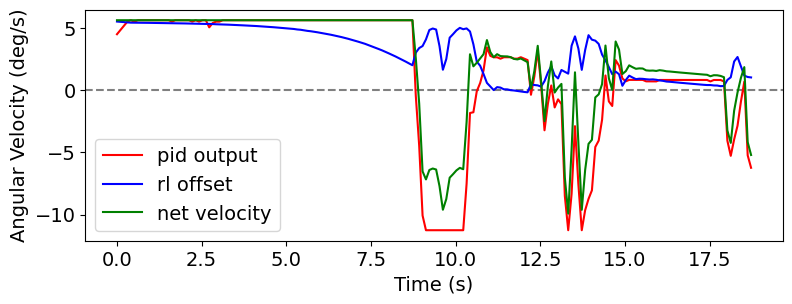

In [9]:
plt.rcParams.update({'font.size': 14})
plot_controller_output(episode_no=24, rollout_data=rollout_data, ep_data=ep_data)

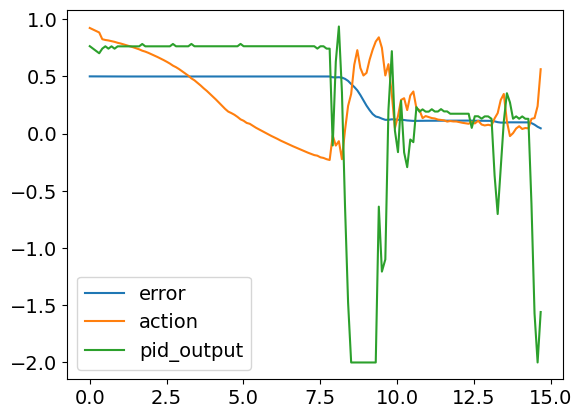

mean_reward: -0.0146
length: 145.0000
return: -2.1186
dispense_time: 17.3774
requested_wt: 30.0000
dispensed_wt: 28.0500
e_penalty: 0.0137
e_dt_penalty: 0.0008
e_d2t_penalty: 0.0001
mean_action: 0.2776
action_max_clip: 0.0207
action_min_clip: 0.0000
is_success: 1.0000


In [10]:
EPISODE_NO = 3
ITEM = ['error', 'action', 'pid_output']
SCALE = [1/60, 1, 1/MAX_ROT_VEL]

start_idx = rollout_data['episode_slice_idx'][EPISODE_NO]
end_idx = rollout_data['episode_slice_idx'][EPISODE_NO+1]

for i, s in zip(ITEM, SCALE):
    plt.plot(rollout_data['time'][start_idx:end_idx], s * rollout_data[i][start_idx:end_idx], label=i)
plt.legend()
plt.show()
for k, v in ep_data.items():
    print(f"{k}: {v[EPISODE_NO]:0.4f}")